In [1]:
import pickle
import pandas as pd

# 데이터 읽어오기
df = pd.read_pickle('path_df.pkl')
exploit=df
exploit

,EID,PATH_NUM,SYSCALL_PATH
0,10613,exit_code,"[102, 1]"
1,10613,exit_code,"[102, 1, 12, 12, 1, 59]"
2,10613,exit_code,"[102, 1]"
3,10613,exit_code,"[102, 1, 12, 12, 1, 59]"
4,10613,main,"[102, 104, 1, 117, 119, 9, 9, 9, 9, 11]"
...,...,...,...
4076,9545,main,"[102, 104, 9, 41]"
4077,9545,main,"[102, 104, 9, 41, 87, 77, 40, 59]"
4078,9545,main,"[102, 104, 9]"
4079,9575,main,"[41, inet_addr, htons, 9, 46, 46, 3, 13, 13, 1..."


In [3]:
# syscall path만 뽑아서 이차원 데이터로 만들기
tokened_syscall_path = [syscall for syscall in df['SYSCALL_PATH']]
tokened_syscall_path[:10]

[['102', '1'],
 ['102', '1', '12', '12', '1', '59'],
 ['102', '1'],
 ['102', '1', '12', '12', '1', '59'],
 ['102', '104', '1', '117', '119', '9', '9', '9', '9', '11'],
 ['102',
  '104',
  '1',
  '117',
  '119',
  '9',
  '9',
  '9',
  '9',
  '11',
  '22',
  '3',
  '13',
  '278'],
 ['102', '104', '1', '117', '119', '9', '9', '9', '9', '11', '22'],
 ['102', '104', '1', '117', '119', '9', '9', '9', '9', '11'],
 ['102',
  '104',
  '1',
  '117',
  '119',
  '9',
  '9',
  '9',
  '9',
  '11',
  '22',
  '3',
  '13',
  '278'],
 ['102', '104', '1', '117', '119', '9', '9', '9', '9', '11', '22']]

In [4]:
dictionary = set()
not_syscall = set()
all =set()
for path in tokened_syscall_path:
    for syscall in path:
        all.add(syscall)
        if str.isdigit(syscall):
            dictionary.add(syscall)
        else:
            if "setns" == syscall:
                dictionary.add("setns")
            if "time" == syscall:
                dictionary.add("time")
            if "capset" == syscall:
                dictionary.add("capset")
            if "fstat" == syscall:
                dictionary.add("fstat")
            if "__NR_vm86old" == syscall:
                dictionary.add("__NR_vm86old")
            else:
                not_syscall.add(syscall)
        
print(len(dictionary))
print(len(all))

137
317


### Word2Vec의 평균을 사용한 Syscall Sequence Embedding
파라미터 의미 참고: https://hoonzi-text.tistory.com/2

In [24]:
# 모든 path 시퀀스 Word2Vec 훈련시키기
from gensim.models import Word2Vec

word2vec_model = Word2Vec(tokened_syscall_path, size=4, window=2, min_count=1, sg=1)

In [25]:
import numpy as np
# 각 exploit에 존재하는 system call들의 vector 값의 평균을 구하여 해당 exploit code의 vector값을 구함
def get_exploit_vectors(document_list):
    document_embedding_list = []

    # 각 Exploit에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line:
            if word in word2vec_model.wv.vocab:
                count += 1
                # 해당 Exploit에 있는 모든 syscall들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = word2vec_model[word]
                else:
                    doc2vec = doc2vec + word2vec_model[word]

        if doc2vec is not None:
            # syscall 벡터를 모두 더한 벡터의 값을 Exploit 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)
        else:
            document_embedding_list.append(np.zeros(100))

    # 각 Exploit에 대한 Exploit 벡터 리스트를 리턴
    return document_embedding_list

In [26]:
exploit_embedding_list = get_exploit_vectors(exploit['SYSCALL_PATH'])
print('문서 벡터의 수 :',len(exploit_embedding_list))

/tmp/ipykernel_2382128/2519065890.py:15: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/tmp/ipykernel_2382128/2519065890.py:17: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



문서 벡터의 수 : 4081


### Cluster 개수 결정

In [27]:
from sklearn.cluster import KMeans as km
inertia = []    # cluster 응집도
for k in range(1,31):    # 50개까지
    km_model = km(n_clusters = k, init='k-means++')
    km_model.fit(exploit_embedding_list)
    inertia.append(km_model.inertia_)

<Figure size 640x440 with 0 Axes>

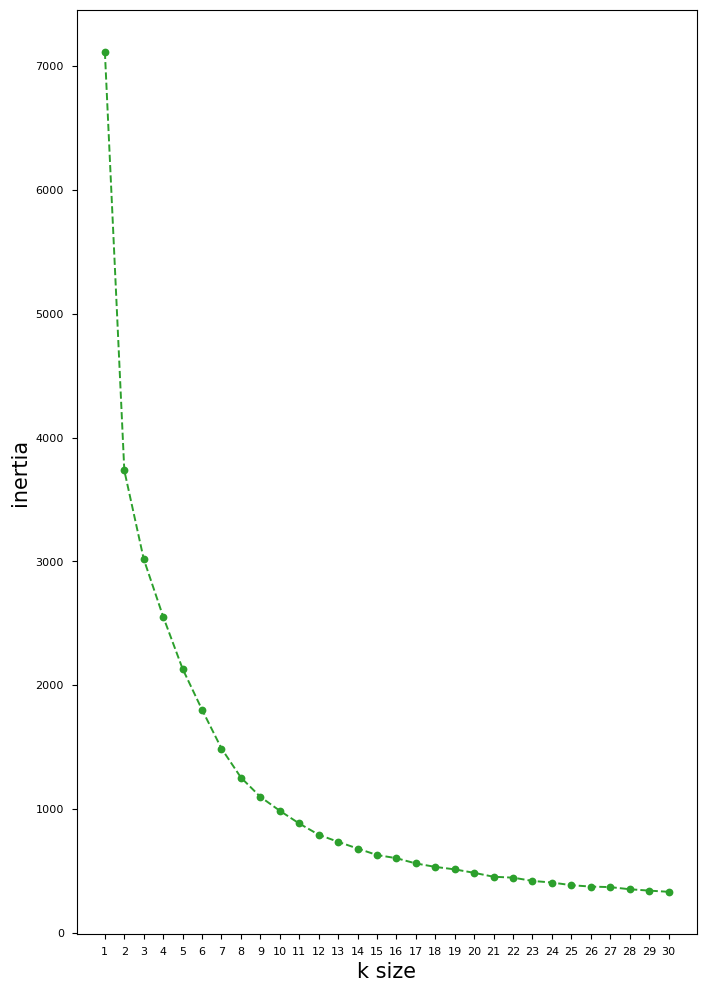

In [28]:
# 그래프로 출력
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np

plt.clf()
plt.style.use('default')
plt.style.use('seaborn-paper')

xpos = np.array(range(1,31))
fig = plt.figure(figsize=(8, 12))
plt.plot(xpos, inertia, marker='o', linestyle='--', color='#2ca02c')
plt.xlabel("k size", fontsize=15)
plt.xticks(xpos, xpos)
plt.ylabel("inertia", fontsize=15)
plt.show()

In [29]:
def unsupervised_learning(data, n): # n = k 수
    # cluster 개수 -> km_model.inertia_ 를 보면 기울기 변화가 적어지는 부분이 20
    km_model = km(n_clusters = n, algorithm = 'full', init='k-means++')
    km_model.fit(data)    # 학습
    predict_list = km_model.predict(data)    # clustering
    return predict_list

In [30]:
km_label = unsupervised_learning(exploit_embedding_list,100)
exploit['km_label'] = km_label
exploit

,EID,PATH_NUM,SYSCALL_PATH,km_label
0,10613,exit_code,"[102, 1]",82
1,10613,exit_code,"[102, 1, 12, 12, 1, 59]",57
2,10613,exit_code,"[102, 1]",82
3,10613,exit_code,"[102, 1, 12, 12, 1, 59]",57
4,10613,main,"[102, 104, 1, 117, 119, 9, 9, 9, 9, 11]",57
...,...,...,...,...
4076,9545,main,"[102, 104, 9, 41]",33
4077,9545,main,"[102, 104, 9, 41, 87, 77, 40, 59]",33
4078,9545,main,"[102, 104, 9]",33
4079,9575,main,"[41, inet_addr, htons, 9, 46, 46, 3, 13, 13, 1...",42


Text(0.5, 1.0, 'PCA Transformed')

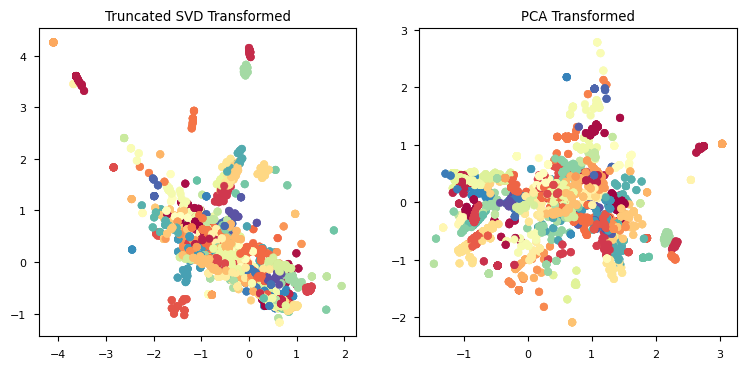

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD, PCA


# 특이값 분해
tsvd = TruncatedSVD(n_components=2)
tsvd.fit(exploit_embedding_list)
scaler = StandardScaler() # exploit 데이터를 StandardScaler로 변환
exploit_tsvd = scaler.fit_transform(exploit_embedding_list)

# 스케일링된 데이터를 기반으로 PCA 변환 수행 
pca = PCA(n_components=2)
pca.fit(exploit_embedding_list)
exploit_pca = pca.transform(exploit_embedding_list)

# TruncatedSVD 변환 데이터를 왼쪽에, PCA변환 데이터를 오른쪽에 표현 
fig, (ax1, ax2) = plt.subplots(figsize=(9,4), ncols=2)
ax1.scatter(x=exploit_tsvd[:,0], y= exploit_tsvd[:,1], c= exploit.km_label, cmap='Spectral')
ax2.scatter(x=exploit_pca[:,0], y= exploit_pca[:,1], c= exploit.km_label, cmap='Spectral')
ax1.set_title('Truncated SVD Transformed')
ax2.set_title('PCA Transformed')

In [22]:
pca = PCA(n_components=3)
components = pca.fit_transform(exploit_embedding_list)

total_var = pca.explained_variance_ratio_.sum() * 100
import plotly.express as px
fig = px.colors.qualitative.swatches()
fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=exploit.km_label,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    color_discrete_sequence=px.colors.qualitative.Dark24
)
fig.show()

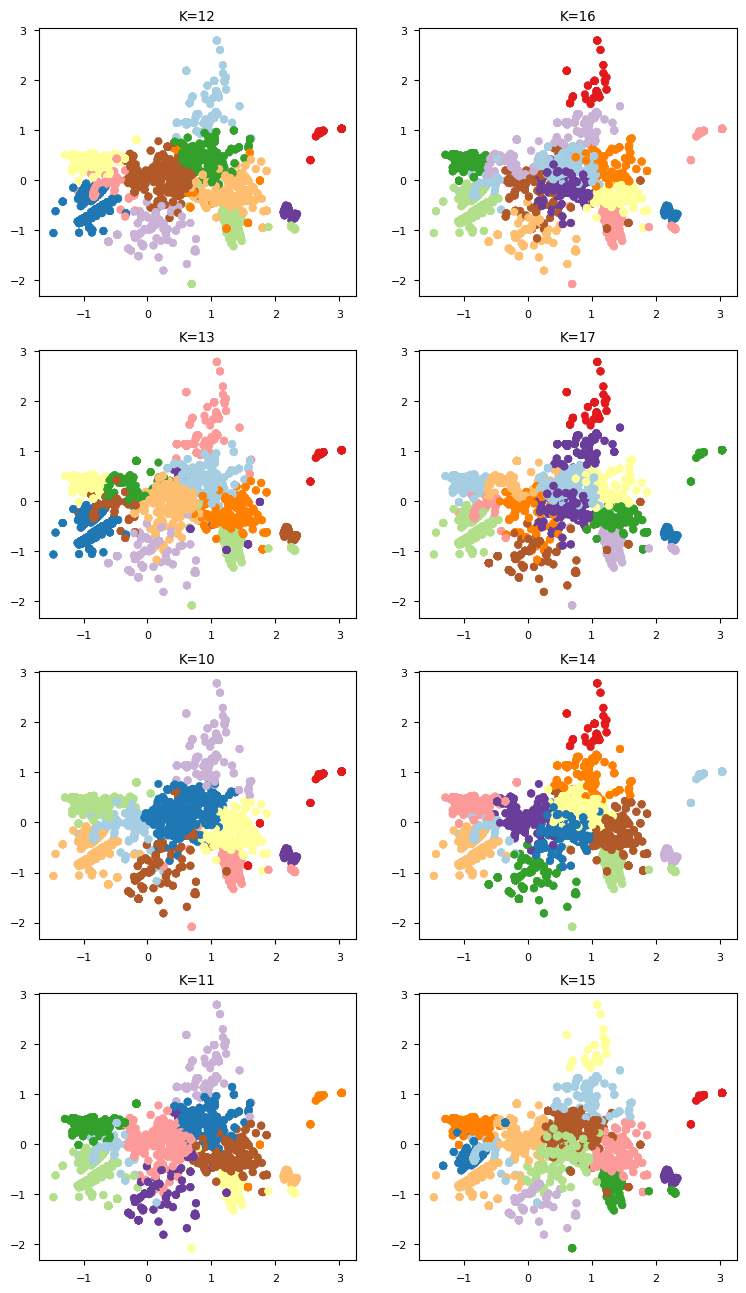

In [32]:
fig, ax = plt.subplots(figsize=(9,16), nrows=4, ncols=2)
j=0
START = 10
for i in range(START,START+8):
    km_label = unsupervised_learning(exploit_embedding_list,i)
    # TruncatedSVD 변환 데이터를 왼쪽에, PCA변환 데이터를 오른쪽에 표현 
    ax[i%4][j].scatter(x=exploit_pca[:,0], y= exploit_pca[:,1], c= km_label, cmap='Paired')
    ax[i%4][j].set_title(f'K={i}')
    if i == START+3:
        j = 1

# 같은 그룹 끼리 Cosine 유사도 비교

In [33]:
k_label = len(set(exploit.km_label))
print("K-Mean++ label 수: ", len(set(exploit.km_label)))

K-Mean++ label 수:  100


In [34]:
same_cluster_exploit = set()
cluster_exploits = list()
for label in range(k_label):
    for idx in exploit[exploit['km_label'] == label].index:
        same_cluster_exploit.add(exploit.loc[idx].EID)
    cluster_exploits.append(same_cluster_exploit.copy())
    same_cluster_exploit = set()

In [35]:
# 익스플로잇 기준 속한 그룹
all_exploits = list(set(exploit['EID']))
for eid in all_exploits:
    print(eid, set(exploit[exploit['EID'] == eid]['km_label'].values)-{0})

25444 {33, 69, 86}
4460 {69, 45, 15, 56, 57}
32751 {50}
20720 {2, 35, 50, 54, 56}
33336 {6, 8, 73, 42, 17, 53, 24, 59, 60, 30}
15023 {6, 15, 17, 56, 89, 59}
2031 {19}
40871 {32, 65, 34, 99, 3, 68, 66, 71, 2, 35, 12, 82, 24, 57, 27}
41886 {53}
8673 {2, 45, 54}
15774 {59, 92, 6}
1397 {14, 79, 82, 19, 25, 87, 89, 59, 92, 62, 31}
31347 {32, 3, 17, 20, 53, 57, 62}
15024 {36, 6, 7, 70, 9, 41, 45, 15, 51, 93, 83, 89, 58, 59, 61}
25450 {5, 74, 12, 19, 57}
20000 {74, 92, 85}
33322 {65, 74}
33523 {5}
9575 {42}
44299 {35, 8, 73, 17, 62}
17391 {32, 6, 8, 73, 44, 20, 53, 89, 92, 94}
17787 {32, 69, 6, 17, 19, 59, 60, 93, 94}
50135 {2, 68, 10, 15, 81, 21, 95}
895 {32, 57, 19, 55}
35161 {33, 2, 69, 43, 12, 45, 15, 81, 20, 85, 54, 22, 56, 57}
14814 {37, 6, 17, 55, 25, 59}
15916 {17, 26, 59, 6}
2006 {19, 62}
25289 {32, 50, 20, 45}
2005 {27, 82, 35, 20}
22363 {56, 57}
41995 {17, 82, 71}
40839 {35, 6, 72, 12, 18, 57}
33824 {32, 74, 43, 5}
24746 {8, 73, 42, 17, 53}
33516 {6, 17, 50, 59, 92}
25288 {37, 43, 

In [36]:
# 그룹 기준 속한 익스플로잇 
all_exploits = list(set(exploit['EID']))
cluster_exploits = list()
for label in range(k_label):
    cluster_exploits.append(list(set(exploit[exploit['km_label'] == label]['EID'])))
for cluster in cluster_exploits:
    print(cluster)

['2004', '2005', '19419', '41458', '47168', '47170', '41994', '38390', '26131']
['45553']
['50135', '40871', '20720', '35161', '8673', '8678', '20721']
['40871', '47170', '31347', '15704']
['44298', '45010']
['25450', '33523', '50541', '926', '41458', '33824', '8678', '41994', '9083', '34923', '38390', '18411']
['5093', '47168', '14814', '40003', '42887', '33336', '44300', '15916', '15023', '15774', '15704', '15024', '43029', '43418', '44303', '40839', '47170', '33516', '47169', '17391', '37722', '40049', '17787', '15285', '45553']
['15024']
['44299', '17391', '24746', '9083', '45553', '18411', '33336']
['15024']
['50135', '9083', '42887', '45553', '18411']
['44302', '45553']
['25450', '27297', '40871', '926', '35161', '40839', '37167', '47170', '25288', '9479', '18411']
['41458']
['25202', '1397']
['15024', '4460', '15023', '50135', '37722', '50541', '35161', '30604', '47163']
['47170', '45553']
['14814', '40003', '15944', '33336', '33589', '44300', '15916', '15023', '15704', '31347',

In [37]:
# EID: Syscall Path 형태로 만들어주기 (기존의 Syscall_Path 모두 붇이기)
exploit_only_one_path = pd.DataFrame( columns = {'EID','SYSCALL_PATH'})
new_data = {"EID":"", "SYSCALL_PATH": list()}
concat_path = list()
for idx in df.index:
    if idx == 0:
        new_data = {"EID":df.loc[idx,'EID'], "SYSCALL_PATH": df.loc[idx,'SYSCALL_PATH']}
    if not df.loc[idx,'EID'] == new_data["EID"]:
        exploit_only_one_path = exploit_only_one_path.append(new_data, ignore_index=True)
        new_data = {"EID":df.loc[idx,'EID'], "SYSCALL_PATH": df.loc[idx,'SYSCALL_PATH']}
        new_data["EID"] = df.loc[idx,'EID']
        new_data["SYSCALL_PATH"].extend(df.loc[idx,'SYSCALL_PATH'])
    else:
        new_data["SYSCALL_PATH"].extend(df.loc[idx,'SYSCALL_PATH'])
exploit_only_one_path

,EID,SYSCALL_PATH
0,10613,"[102, 1, 102, 1, 102, 1, 12, 12, 1, 59, 102, 1..."
1,12,"[101, 101, 101, 101, 101, 101, 101, 101, 101, ..."
2,1397,"[125, 125, 125, 125, 125, 125, 125, 125, 125, ..."
3,14814,"[prepare_kernel_cred, commit_cred, prepare_ker..."
4,15023,"[prepare_kernel_cred, commit_cred, prepare_ker..."
...,...,...
96,9083,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 203, 203, 12, 12, ..."
97,926,"[13, 13, 14, 9, 14, 56, 11, 14, 61, 13, 13, 14..."
98,9479,"[102, 104, 135, 10, 257, 41, 40, 3, 41, 102, 4..."
99,9542,"[102, 104, 135, 9, 41, 44, 44, 102, 102, 104, ..."


In [38]:
# 각 exploit에 존재하는 system call들의 vector 값의 평균을 구하여 해당 exploit code의 vector값을 구함
def get_exploit_vectors(document_list):
    document_embedding_list = []

    # 각 Exploit에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line:
            if word in word2vec_model.wv.vocab:
                count += 1
                # 해당 Exploit에 있는 모든 syscall들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = word2vec_model[word]
                else:
                    doc2vec = doc2vec + word2vec_model[word]

        if doc2vec is not None:
            # syscall 벡터를 모두 더한 벡터의 값을 Exploit 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    # 각 Exploit에 대한 Exploit 벡터 리스트를 리턴
    return document_embedding_list

exploit_only_one_path_embedding_list = get_exploit_vectors(exploit_only_one_path['SYSCALL_PATH'])
print('문서 벡터의 수 :',len(exploit_only_one_path_embedding_list))

/tmp/ipykernel_2382128/167459078.py:14: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/tmp/ipykernel_2382128/167459078.py:16: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



문서 벡터의 수 : 101


In [39]:
from sklearn.metrics.pairwise import cosine_similarity
sim_df = list()
exploit_cosine_similarities = list()
sim_exploit_list = list()
xyticklabels = list()
for i, exploits in enumerate(cluster_exploits):
    for eid in exploits:
        if len(exploit_only_one_path[exploit_only_one_path['EID']==eid].index) > 0:
            idx = exploit_only_one_path[exploit_only_one_path['EID']==eid].index[0]
            sim_df.append(exploit_only_one_path_embedding_list[idx])
            sim_exploit_list.append(exploit_only_one_path.loc[idx].EID)
        
    exploit_cosine_similarities.append( cosine_similarity( sim_df, sim_df))
    print(f'Label {i} 코사인 유사도 매트릭스의 크기 :',exploit_cosine_similarities[i].shape)
    sim_df = []
    xyticklabels.append(sim_exploit_list.copy())
    sim_exploit_list = []

Label 0 코사인 유사도 매트릭스의 크기 : (9, 9)
Label 1 코사인 유사도 매트릭스의 크기 : (1, 1)
Label 2 코사인 유사도 매트릭스의 크기 : (7, 7)
Label 3 코사인 유사도 매트릭스의 크기 : (4, 4)
Label 4 코사인 유사도 매트릭스의 크기 : (2, 2)
Label 5 코사인 유사도 매트릭스의 크기 : (12, 12)
Label 6 코사인 유사도 매트릭스의 크기 : (25, 25)
Label 7 코사인 유사도 매트릭스의 크기 : (1, 1)
Label 8 코사인 유사도 매트릭스의 크기 : (7, 7)
Label 9 코사인 유사도 매트릭스의 크기 : (1, 1)
Label 10 코사인 유사도 매트릭스의 크기 : (5, 5)
Label 11 코사인 유사도 매트릭스의 크기 : (2, 2)
Label 12 코사인 유사도 매트릭스의 크기 : (11, 11)
Label 13 코사인 유사도 매트릭스의 크기 : (1, 1)
Label 14 코사인 유사도 매트릭스의 크기 : (2, 2)
Label 15 코사인 유사도 매트릭스의 크기 : (9, 9)
Label 16 코사인 유사도 매트릭스의 크기 : (2, 2)
Label 17 코사인 유사도 매트릭스의 크기 : (21, 21)
Label 18 코사인 유사도 매트릭스의 크기 : (10, 10)
Label 19 코사인 유사도 매트릭스의 크기 : (17, 17)
Label 20 코사인 유사도 매트릭스의 크기 : (14, 14)
Label 21 코사인 유사도 매트릭스의 크기 : (1, 1)
Label 22 코사인 유사도 매트릭스의 크기 : (9, 9)
Label 23 코사인 유사도 매트릭스의 크기 : (2, 2)
Label 24 코사인 유사도 매트릭스의 크기 : (6, 6)
Label 25 코사인 유사도 매트릭스의 크기 : (10, 10)
Label 26 코사인 유사도 매트릭스의 크기 : (4, 4)
Label 27 코사인 유사도 매트릭스의 크기 : (11, 11)
Label 28 코사인

<Figure size 640x440 with 0 Axes>

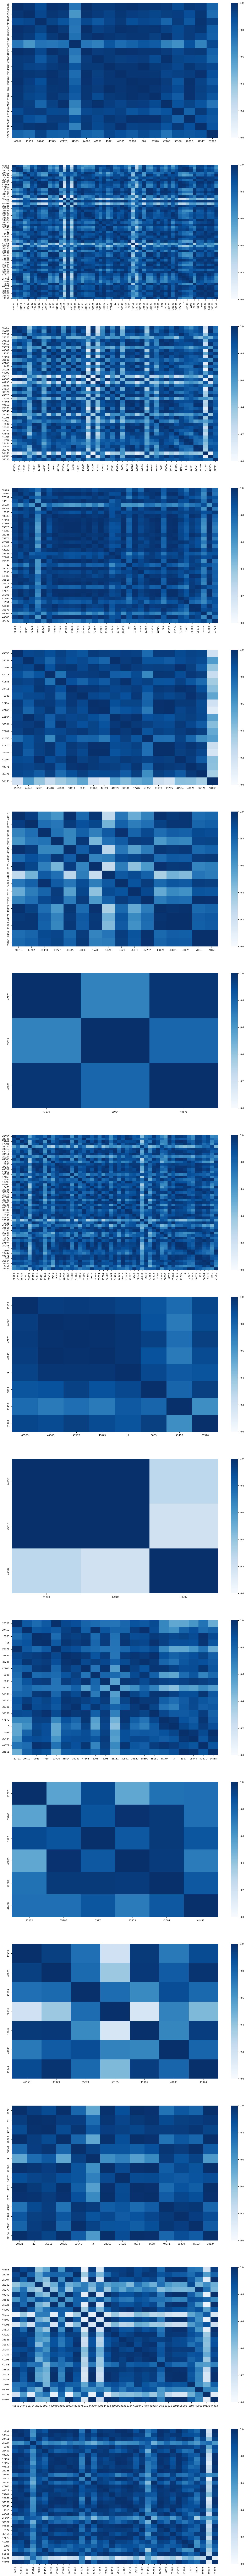

In [307]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.reset_orig()
plt.clf()
figure, ax = plt.subplots(nrows = k_label, ncols =1 )
figure.set_size_inches(k_label,k_label*10)


for i in range(k_label):
    sns.heatmap(exploit_cosine_similarities[i], xticklabels= xyticklabels[i], yticklabels= xyticklabels[i], cmap='Blues', vmin=0, vmax=1, annot=False, ax = ax[i])
